In [1]:
import numpy as np
import pandas as pd
import math

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
pd.options.display.float_format = '{:.2f}'.format
# pd.options.display.max_rows = None  # 모든 row 내용 print
pd.options.display.max_rows = 20

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.

In [3]:
# Provide the names for the columns since the CSV file with the data does not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']

In [4]:
# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                     sep=',', names=feature_names, header=None, encoding='latin-1')

 We'll then randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent.

In [5]:
car_data = car_data.reindex(np.random.permutation(car_data.index))
# or equivalently,
# car_data = car_data.sample(frac=1)

In [6]:
print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


In [7]:
car_data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
23,1,118,dodge,gas,turbo,two,hatchback,fwd,front,93.70,...,98,mpfi,3.03,3.39,7.60,102,5500,24,30,7957
95,1,128,nissan,gas,std,two,hatchback,fwd,front,94.50,...,97,2bbl,3.15,3.29,9.40,69,5200,31,37,7799
21,1,118,dodge,gas,std,two,hatchback,fwd,front,93.70,...,90,2bbl,2.97,3.23,9.41,68,5500,37,41,5572
114,0,?,peugot,diesel,turbo,four,wagon,rwd,front,114.20,...,152,idi,3.70,3.52,21.00,95,4150,25,25,17075
17,0,?,bmw,gas,std,four,sedan,rwd,front,110.00,...,209,mpfi,3.62,3.39,8.00,182,5400,15,20,36880


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [8]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
17,0,?,bmw,gas,std,four,sedan,rwd,front,110.00,...,209,mpfi,3.62,3.39,8.00,182,5400,15,20,36880
94,1,128,nissan,gas,std,two,sedan,fwd,front,94.50,...,97,2bbl,3.15,3.29,9.40,69,5200,31,37,7299
164,1,168,toyota,gas,std,two,hatchback,rwd,front,94.50,...,98,2bbl,3.19,3.03,9.00,70,4800,29,34,8238


In [9]:
car_data.describe()

,symboling,wheel-base,length,width,height,weight,engine-size,compression-ratio,city-mpg,highway-mpg
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,98.76,174.05,65.91,53.72,2555.57,126.91,10.14,25.22,30.75
std,1.25,6.02,12.34,2.15,2.44,520.68,41.64,3.97,6.54,6.89
min,-2.00,86.60,141.10,60.30,47.80,1488.00,61.00,7.00,13.00,16.00
25%,0.00,94.50,166.30,64.10,52.00,2145.00,97.00,8.60,19.00,25.00
50%,1.00,97.00,173.20,65.50,54.10,2414.00,120.00,9.00,24.00,30.00
75%,2.00,102.40,183.10,66.90,55.50,2935.00,141.00,9.40,30.00,34.00
max,3.00,120.90,208.10,72.30,59.80,4066.00,326.00,23.00,49.00,54.00


In [10]:
LABEL = 'price'

numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

categorical_feature_names

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [11]:
# The correct solution will pass these assert statements.
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [12]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
23,1,118,93.70,157.30,63.80,50.80,2128,98,102,5500,24,30,3.03,3.39,7.60
95,1,128,94.50,165.60,63.80,53.30,2028,97,69,5200,31,37,3.15,3.29,9.40
21,1,118,93.70,157.30,63.80,50.80,1876,90,68,5500,37,41,2.97,3.23,9.41
114,0,?,114.20,198.90,68.40,58.70,3485,152,95,4150,25,25,3.70,3.52,21.00
17,0,?,110.00,197.00,70.90,56.30,3505,209,182,5400,15,20,3.62,3.39,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2,104,99.10,186.60,66.50,56.10,2847,121,160,5500,19,26,3.54,3.07,9.00
86,1,125,96.30,172.40,65.40,51.60,2405,122,88,5000,25,32,3.35,3.46,8.50
108,0,161,107.90,186.70,68.40,56.70,3197,152,95,4150,28,33,3.70,3.52,21.00
121,1,154,93.70,167.30,63.80,50.80,1989,90,68,5500,31,38,2.97,3.23,9.40


In [13]:
car_data[numeric_feature_names].describe()

,symboling,wheel-base,length,width,height,weight,engine-size,city-mpg,highway-mpg,compression-ratio
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,98.76,174.05,65.91,53.72,2555.57,126.91,25.22,30.75,10.14
std,1.25,6.02,12.34,2.15,2.44,520.68,41.64,6.54,6.89,3.97
min,-2.00,86.60,141.10,60.30,47.80,1488.00,61.00,13.00,16.00,7.00
25%,0.00,94.50,166.30,64.10,52.00,2145.00,97.00,19.00,25.00,8.60
50%,1.00,97.00,173.20,65.50,54.10,2414.00,120.00,24.00,30.00,9.00
75%,2.00,102.40,183.10,66.90,55.50,2935.00,141.00,30.00,34.00,9.40
max,3.00,120.90,208.10,72.30,59.80,4066.00,326.00,49.00,54.00,23.00


In [14]:
# Coerce the numeric features to numbers. This is necessary because the model crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
    car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors ='coerce')

"""
errors: error는 총 3개의 옵션이 존재합니다.
- errors = 'ignore' -> 만약 숫자로 변경할 수 없는 데이터라면 숫자로 변경하지 않고 원본 데이터를 그대로 반환합니다.
- errors = 'coerce' -> 만약 숫자로 변경할 수 없는 데이터라면 기존 데이터를 지우고 NaN으로 설정하여 반환합니다.
- errors = 'raise' -> 만약 숫자로 변경할 수 없는 데이터라면 에러를 일으키며 코드를 중단합니다."""
    
# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [15]:
car_data.shape

(205, 26)

In [16]:
X = car_data[numeric_feature_names].copy()
y = car_data['price'].copy()

In [17]:
X.columns

Index(['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'bore', 'stroke', 'compression-ratio'],
      dtype='object')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 )

In [22]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=3, input_shape=(15,), activation='relu'))
model.add(tf.keras.layers.Dense(units=1))
model.compile(tf.keras.optimizers.Adam(learning_rate=0.01),
             loss='mean_squared_error',
             metrics=[tf.keras.metrics.MeanSquaredError()])

In [23]:
batch_size=16
epochs=1000
model.fit(X_train, y_train, epochs=epochs, batch_size= batch_size)

Epoch 1/1000
11/11 [==============================] - 0s 599us/step - loss: 221485424.0000 - mean_squared_error: 221485424.0000
Epoch 2/1000
11/11 [==============================] - 0s 601us/step - loss: 218845584.0000 - mean_squared_error: 218845584.0000
Epoch 3/1000
11/11 [==============================] - 0s 495us/step - loss: 218802800.0000 - mean_squared_error: 218802800.0000
Epoch 4/1000
11/11 [==============================] - 0s 798us/step - loss: 218785984.0000 - mean_squared_error: 218785984.0000
Epoch 5/1000
11/11 [==============================] - 0s 497us/step - loss: 218779728.0000 - mean_squared_error: 218779728.0000
Epoch 6/1000
11/11 [==============================] - 0s 701us/step - loss: 218773008.0000 - mean_squared_error: 218773008.0000
Epoch 7/1000
11/11 [==============================] - 0s 501us/step - loss: 218767360.0000 - mean_squared_error: 218767360.0000
Epoch 8/1000
11/11 [==============================] - 0s 598us/step - loss: 218761088.0000 - mean_square

11/11 [==============================] - 0s 426us/step - loss: 218519408.0000 - mean_squared_error: 218519408.0000
Epoch 65/1000
11/11 [==============================] - 0s 496us/step - loss: 218516656.0000 - mean_squared_error: 218516656.0000
Epoch 66/1000
11/11 [==============================] - 0s 598us/step - loss: 218513904.0000 - mean_squared_error: 218513904.0000
Epoch 67/1000
11/11 [==============================] - 0s 499us/step - loss: 218511104.0000 - mean_squared_error: 218511104.0000
Epoch 68/1000
11/11 [==============================] - 0s 494us/step - loss: 218508336.0000 - mean_squared_error: 218508336.0000
Epoch 69/1000
11/11 [==============================] - 0s 500us/step - loss: 218505648.0000 - mean_squared_error: 218505648.0000
Epoch 70/1000
11/11 [==============================] - 0s 499us/step - loss: 218502896.0000 - mean_squared_error: 218502896.0000
Epoch 71/1000
11/11 [==============================] - 0s 420us/step - loss: 218500144.0000 - mean_squared_erro

11/11 [==============================] - 0s 601us/step - loss: 218346928.0000 - mean_squared_error: 218346928.0000
Epoch 128/1000
11/11 [==============================] - 0s 496us/step - loss: 218344272.0000 - mean_squared_error: 218344272.0000
Epoch 129/1000
11/11 [==============================] - 0s 501us/step - loss: 218341504.0000 - mean_squared_error: 218341504.0000
Epoch 130/1000
11/11 [==============================] - 0s 496us/step - loss: 218338784.0000 - mean_squared_error: 218338784.0000
Epoch 131/1000
11/11 [==============================] - 0s 499us/step - loss: 218335952.0000 - mean_squared_error: 218335952.0000
Epoch 132/1000
11/11 [==============================] - 0s 500us/step - loss: 218333152.0000 - mean_squared_error: 218333152.0000
Epoch 133/1000
11/11 [==============================] - 0s 431us/step - loss: 218330432.0000 - mean_squared_error: 218330432.0000
Epoch 134/1000
11/11 [==============================] - 0s 598us/step - loss: 218327632.0000 - mean_squar

11/11 [==============================] - 0s 496us/step - loss: 218175760.0000 - mean_squared_error: 218175760.0000
Epoch 191/1000
11/11 [==============================] - 0s 556us/step - loss: 218172992.0000 - mean_squared_error: 218172992.0000
Epoch 192/1000
11/11 [==============================] - 0s 487us/step - loss: 218170272.0000 - mean_squared_error: 218170272.0000
Epoch 193/1000
11/11 [==============================] - 0s 499us/step - loss: 218167520.0000 - mean_squared_error: 218167520.0000
Epoch 194/1000
11/11 [==============================] - 0s 401us/step - loss: 218164880.0000 - mean_squared_error: 218164880.0000
Epoch 195/1000
11/11 [==============================] - 0s 698us/step - loss: 218162144.0000 - mean_squared_error: 218162144.0000
Epoch 196/1000
11/11 [==============================] - 0s 549us/step - loss: 218159456.0000 - mean_squared_error: 218159456.0000
Epoch 197/1000
11/11 [==============================] - 0s 496us/step - loss: 218156736.0000 - mean_squar

11/11 [==============================] - 0s 502us/step - loss: 218004048.0000 - mean_squared_error: 218004048.0000
Epoch 254/1000
11/11 [==============================] - 0s 499us/step - loss: 218001312.0000 - mean_squared_error: 218001312.0000
Epoch 255/1000
11/11 [==============================] - 0s 496us/step - loss: 217998608.0000 - mean_squared_error: 217998608.0000
Epoch 256/1000
11/11 [==============================] - 0s 546us/step - loss: 217995920.0000 - mean_squared_error: 217995920.0000
Epoch 257/1000
11/11 [==============================] - 0s 538us/step - loss: 217993248.0000 - mean_squared_error: 217993248.0000
Epoch 258/1000
11/11 [==============================] - 0s 520us/step - loss: 217990512.0000 - mean_squared_error: 217990512.0000
Epoch 259/1000
11/11 [==============================] - 0s 401us/step - loss: 217987792.0000 - mean_squared_error: 217987792.0000
Epoch 260/1000
11/11 [==============================] - 0s 496us/step - loss: 217985072.0000 - mean_squar

11/11 [==============================] - 0s 499us/step - loss: 217832848.0000 - mean_squared_error: 217832848.0000
Epoch 317/1000
11/11 [==============================] - 0s 598us/step - loss: 217830208.0000 - mean_squared_error: 217830208.0000
Epoch 318/1000
11/11 [==============================] - 0s 463us/step - loss: 217827424.0000 - mean_squared_error: 217827424.0000
Epoch 319/1000
11/11 [==============================] - 0s 399us/step - loss: 217824624.0000 - mean_squared_error: 217824624.0000
Epoch 320/1000
11/11 [==============================] - 0s 597us/step - loss: 217821936.0000 - mean_squared_error: 217821936.0000
Epoch 321/1000
11/11 [==============================] - 0s 496us/step - loss: 217819184.0000 - mean_squared_error: 217819184.0000
Epoch 322/1000
11/11 [==============================] - 0s 501us/step - loss: 217816416.0000 - mean_squared_error: 217816416.0000
Epoch 323/1000
11/11 [==============================] - 0s 496us/step - loss: 217813760.0000 - mean_squar

11/11 [==============================] - 0s 492us/step - loss: 217661840.0000 - mean_squared_error: 217661840.0000
Epoch 380/1000
11/11 [==============================] - 0s 500us/step - loss: 217659136.0000 - mean_squared_error: 217659136.0000
Epoch 381/1000
11/11 [==============================] - 0s 498us/step - loss: 217656352.0000 - mean_squared_error: 217656352.0000
Epoch 382/1000
11/11 [==============================] - 0s 499us/step - loss: 217653680.0000 - mean_squared_error: 217653680.0000
Epoch 383/1000
11/11 [==============================] - 0s 496us/step - loss: 217650976.0000 - mean_squared_error: 217650976.0000
Epoch 384/1000
11/11 [==============================] - 0s 498us/step - loss: 217648256.0000 - mean_squared_error: 217648256.0000
Epoch 385/1000
11/11 [==============================] - 0s 496us/step - loss: 217645504.0000 - mean_squared_error: 217645504.0000
Epoch 386/1000
11/11 [==============================] - 0s 595us/step - loss: 217642816.0000 - mean_squar

11/11 [==============================] - 0s 600us/step - loss: 217490624.0000 - mean_squared_error: 217490624.0000
Epoch 443/1000
11/11 [==============================] - 0s 498us/step - loss: 217487904.0000 - mean_squared_error: 217487904.0000
Epoch 444/1000
11/11 [==============================] - 0s 596us/step - loss: 217485168.0000 - mean_squared_error: 217485168.0000
Epoch 445/1000
11/11 [==============================] - 0s 499us/step - loss: 217482432.0000 - mean_squared_error: 217482432.0000
Epoch 446/1000
11/11 [==============================] - 0s 499us/step - loss: 217479712.0000 - mean_squared_error: 217479712.0000
Epoch 447/1000
11/11 [==============================] - 0s 397us/step - loss: 217476992.0000 - mean_squared_error: 217476992.0000
Epoch 448/1000
11/11 [==============================] - 0s 499us/step - loss: 217474240.0000 - mean_squared_error: 217474240.0000
Epoch 449/1000
11/11 [==============================] - 0s 562us/step - loss: 217471568.0000 - mean_squar

11/11 [==============================] - 0s 478us/step - loss: 217319104.0000 - mean_squared_error: 217319104.0000
Epoch 506/1000
11/11 [==============================] - 0s 501us/step - loss: 217316352.0000 - mean_squared_error: 217316352.0000
Epoch 507/1000
11/11 [==============================] - 0s 466us/step - loss: 217313680.0000 - mean_squared_error: 217313680.0000
Epoch 508/1000
11/11 [==============================] - 0s 496us/step - loss: 217310976.0000 - mean_squared_error: 217310976.0000
Epoch 509/1000
11/11 [==============================] - 0s 559us/step - loss: 217308240.0000 - mean_squared_error: 217308240.0000
Epoch 510/1000
11/11 [==============================] - 0s 499us/step - loss: 217305568.0000 - mean_squared_error: 217305568.0000
Epoch 511/1000
11/11 [==============================] - 0s 499us/step - loss: 217302784.0000 - mean_squared_error: 217302784.0000
Epoch 512/1000
11/11 [==============================] - 0s 396us/step - loss: 217300096.0000 - mean_squar

11/11 [==============================] - 0s 596us/step - loss: 217147824.0000 - mean_squared_error: 217147824.0000
Epoch 569/1000
11/11 [==============================] - 0s 419us/step - loss: 217145024.0000 - mean_squared_error: 217145024.0000
Epoch 570/1000
11/11 [==============================] - 0s 499us/step - loss: 217142368.0000 - mean_squared_error: 217142368.0000
Epoch 571/1000
11/11 [==============================] - 0s 574us/step - loss: 217139632.0000 - mean_squared_error: 217139632.0000
Epoch 572/1000
11/11 [==============================] - 0s 494us/step - loss: 217137024.0000 - mean_squared_error: 217137024.0000
Epoch 573/1000
11/11 [==============================] - 0s 598us/step - loss: 217134336.0000 - mean_squared_error: 217134336.0000
Epoch 574/1000
11/11 [==============================] - 0s 596us/step - loss: 217131552.0000 - mean_squared_error: 217131552.0000
Epoch 575/1000
11/11 [==============================] - 0s 499us/step - loss: 217128704.0000 - mean_squar

11/11 [==============================] - 0s 568us/step - loss: 216976352.0000 - mean_squared_error: 216976352.0000
Epoch 632/1000
11/11 [==============================] - 0s 503us/step - loss: 216973632.0000 - mean_squared_error: 216973632.0000
Epoch 633/1000
11/11 [==============================] - 0s 499us/step - loss: 216970960.0000 - mean_squared_error: 216970960.0000
Epoch 634/1000
11/11 [==============================] - 0s 499us/step - loss: 216968320.0000 - mean_squared_error: 216968320.0000
Epoch 635/1000
11/11 [==============================] - 0s 562us/step - loss: 216965616.0000 - mean_squared_error: 216965616.0000
Epoch 636/1000
11/11 [==============================] - 0s 602us/step - loss: 216962928.0000 - mean_squared_error: 216962928.0000
Epoch 637/1000
11/11 [==============================] - 0s 500us/step - loss: 216960192.0000 - mean_squared_error: 216960192.0000
Epoch 638/1000
11/11 [==============================] - 0s 499us/step - loss: 216957552.0000 - mean_squar

11/11 [==============================] - 0s 499us/step - loss: 216805456.0000 - mean_squared_error: 216805456.0000
Epoch 695/1000
11/11 [==============================] - 0s 501us/step - loss: 216802656.0000 - mean_squared_error: 216802656.0000
Epoch 696/1000
11/11 [==============================] - 0s 499us/step - loss: 216800032.0000 - mean_squared_error: 216800032.0000
Epoch 697/1000
11/11 [==============================] - 0s 596us/step - loss: 216797328.0000 - mean_squared_error: 216797328.0000
Epoch 698/1000
11/11 [==============================] - 0s 594us/step - loss: 216794592.0000 - mean_squared_error: 216794592.0000
Epoch 699/1000
11/11 [==============================] - 0s 502us/step - loss: 216791920.0000 - mean_squared_error: 216791920.0000
Epoch 700/1000
11/11 [==============================] - 0s 499us/step - loss: 216789136.0000 - mean_squared_error: 216789136.0000
Epoch 701/1000
11/11 [==============================] - 0s 528us/step - loss: 216786464.0000 - mean_squar

11/11 [==============================] - 0s 496us/step - loss: 216637120.0000 - mean_squared_error: 216637120.0000
Epoch 757/1000
11/11 [==============================] - 0s 525us/step - loss: 216634464.0000 - mean_squared_error: 216634464.0000
Epoch 758/1000
11/11 [==============================] - 0s 399us/step - loss: 216631792.0000 - mean_squared_error: 216631792.0000
Epoch 759/1000
11/11 [==============================] - 0s 598us/step - loss: 216629024.0000 - mean_squared_error: 216629024.0000
Epoch 760/1000
11/11 [==============================] - 0s 519us/step - loss: 216626432.0000 - mean_squared_error: 216626432.0000
Epoch 761/1000
11/11 [==============================] - 0s 499us/step - loss: 216623680.0000 - mean_squared_error: 216623680.0000
Epoch 762/1000
11/11 [==============================] - 0s 399us/step - loss: 216621008.0000 - mean_squared_error: 216621008.0000
Epoch 763/1000
11/11 [==============================] - 0s 496us/step - loss: 216618336.0000 - mean_squar

11/11 [==============================] - 0s 499us/step - loss: 216466624.0000 - mean_squared_error: 216466624.0000
Epoch 820/1000
11/11 [==============================] - 0s 551us/step - loss: 216463888.0000 - mean_squared_error: 216463888.0000
Epoch 821/1000
11/11 [==============================] - 0s 499us/step - loss: 216461168.0000 - mean_squared_error: 216461168.0000
Epoch 822/1000
11/11 [==============================] - 0s 497us/step - loss: 216458512.0000 - mean_squared_error: 216458512.0000
Epoch 823/1000
11/11 [==============================] - 0s 496us/step - loss: 216455872.0000 - mean_squared_error: 216455872.0000
Epoch 824/1000
11/11 [==============================] - 0s 499us/step - loss: 216453168.0000 - mean_squared_error: 216453168.0000
Epoch 825/1000
11/11 [==============================] - 0s 396us/step - loss: 216450544.0000 - mean_squared_error: 216450544.0000
Epoch 826/1000
11/11 [==============================] - 0s 596us/step - loss: 216447808.0000 - mean_squar

11/11 [==============================] - 0s 598us/step - loss: 216296016.0000 - mean_squared_error: 216296016.0000
Epoch 883/1000
11/11 [==============================] - 0s 495us/step - loss: 216293296.0000 - mean_squared_error: 216293296.0000
Epoch 884/1000
11/11 [==============================] - 0s 507us/step - loss: 216290608.0000 - mean_squared_error: 216290608.0000
Epoch 885/1000
11/11 [==============================] - 0s 396us/step - loss: 216287952.0000 - mean_squared_error: 216287952.0000
Epoch 886/1000
11/11 [==============================] - 0s 498us/step - loss: 216285184.0000 - mean_squared_error: 216285184.0000
Epoch 887/1000
11/11 [==============================] - 0s 503us/step - loss: 216282432.0000 - mean_squared_error: 216282432.0000
Epoch 888/1000
11/11 [==============================] - 0s 501us/step - loss: 216279760.0000 - mean_squared_error: 216279760.0000
Epoch 889/1000
11/11 [==============================] - 0s 494us/step - loss: 216277024.0000 - mean_squar

11/11 [==============================] - 0s 496us/step - loss: 216125632.0000 - mean_squared_error: 216125632.0000
Epoch 946/1000
11/11 [==============================] - 0s 499us/step - loss: 216122960.0000 - mean_squared_error: 216122960.0000
Epoch 947/1000
11/11 [==============================] - 0s 399us/step - loss: 216120224.0000 - mean_squared_error: 216120224.0000
Epoch 948/1000
11/11 [==============================] - 0s 600us/step - loss: 216117472.0000 - mean_squared_error: 216117472.0000
Epoch 949/1000
11/11 [==============================] - 0s 497us/step - loss: 216114928.0000 - mean_squared_error: 216114928.0000
Epoch 950/1000
11/11 [==============================] - 0s 596us/step - loss: 216112208.0000 - mean_squared_error: 216112208.0000
Epoch 951/1000
11/11 [==============================] - ETA: 0s - loss: 218256848.0000 - mean_squared_error: 218256848.00 - 0s 399us/step - loss: 216109536.0000 - mean_squared_error: 216109536.0000
Epoch 952/1000
11/11 [===============

In [24]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 1ms/step - loss: 285315456.0000 - mean_squared_error: 285315456.0000


[285315456.0, 285315456.0]

### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


In [ ]:
def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.
  
  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]
  
  num_cols = 3
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)
  
  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

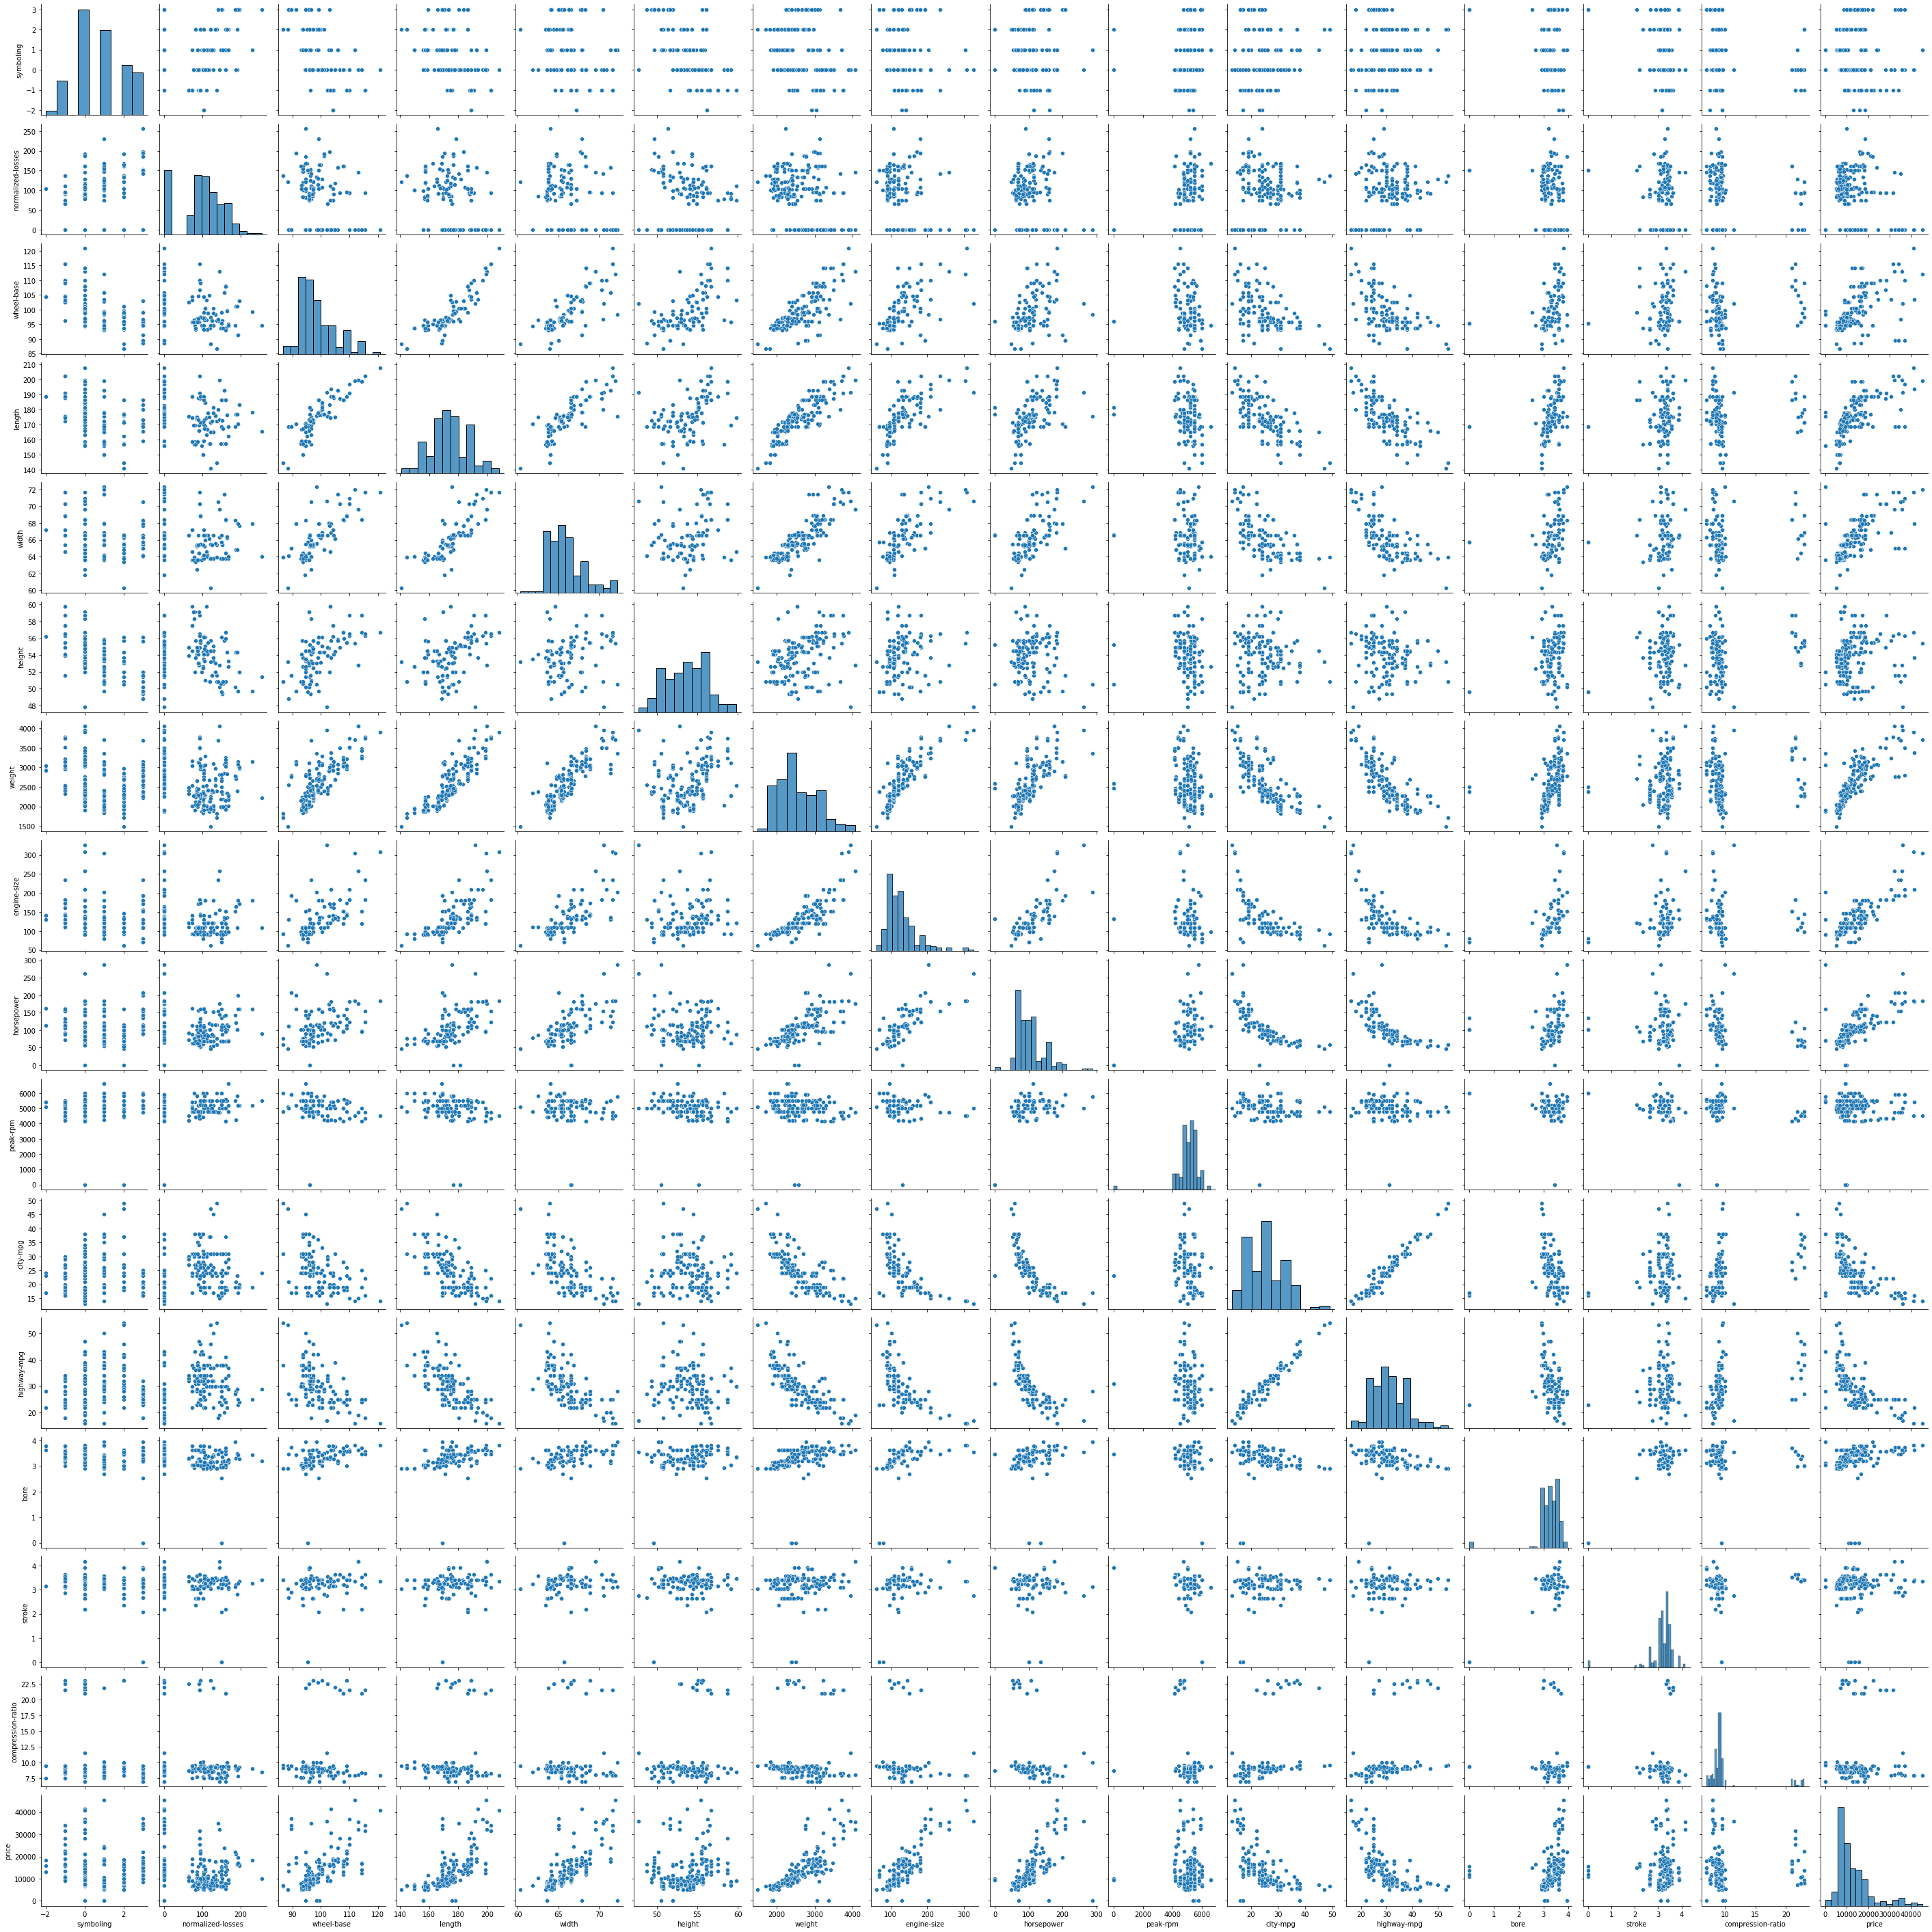

In [29]:
feature_list = ['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'bore', 'stroke', 'compression-ratio', 'price']
sns.pairplot(car_data[feature_list], markers=["o", "s", "D"])

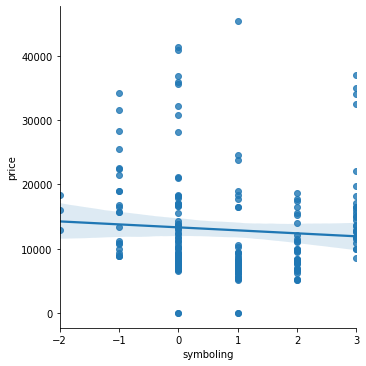

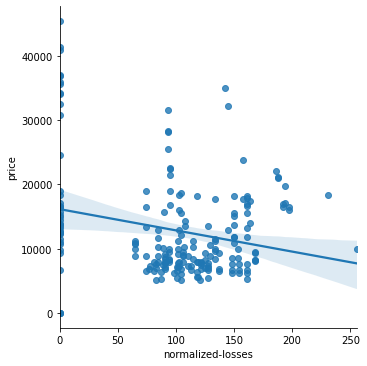

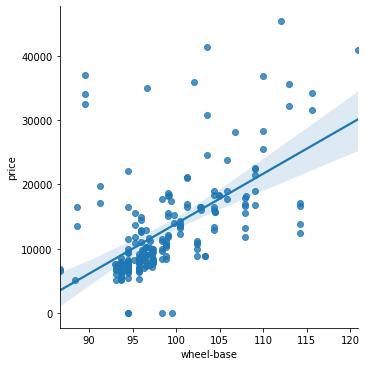

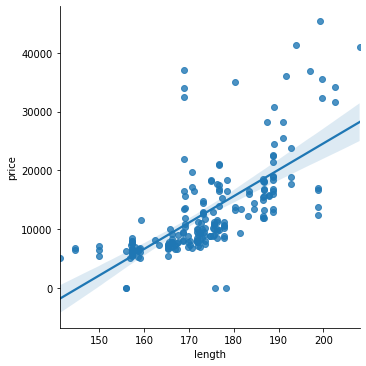

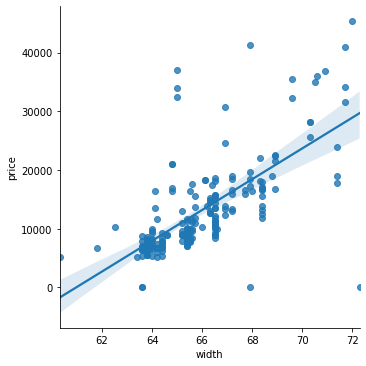

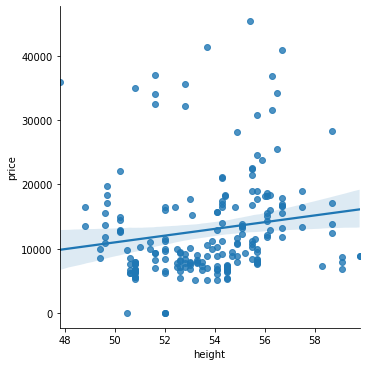

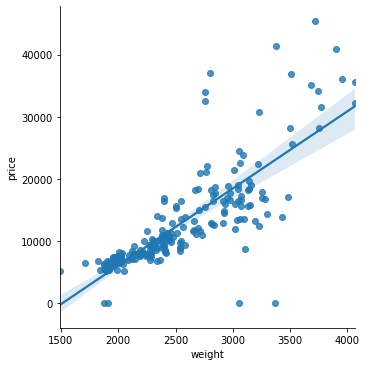

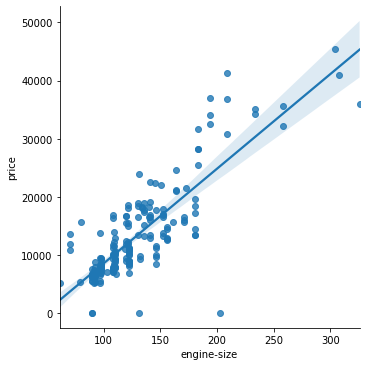

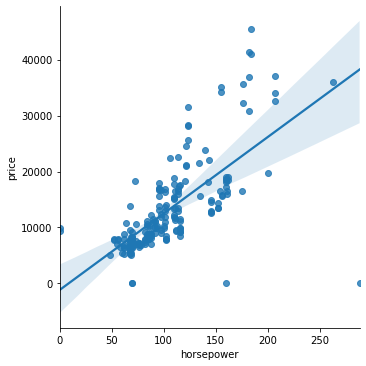

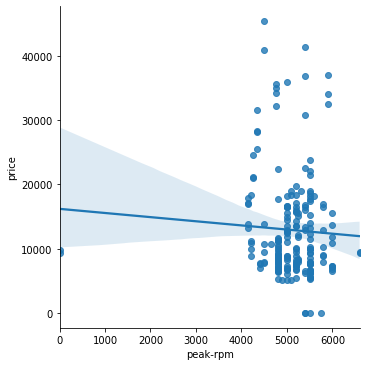

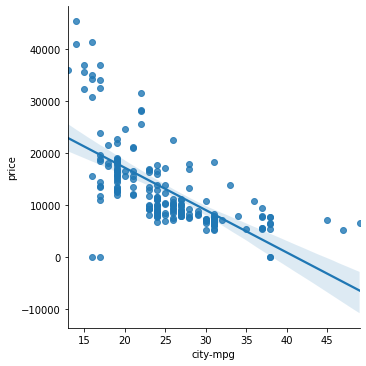

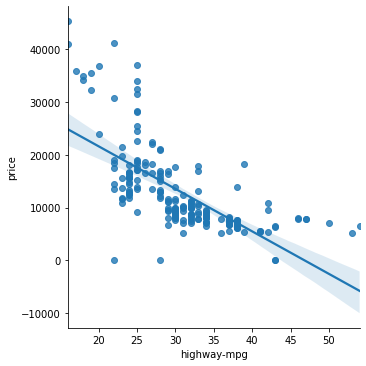

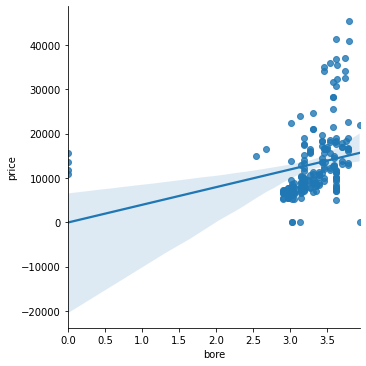

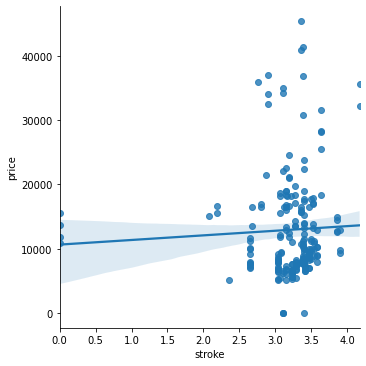

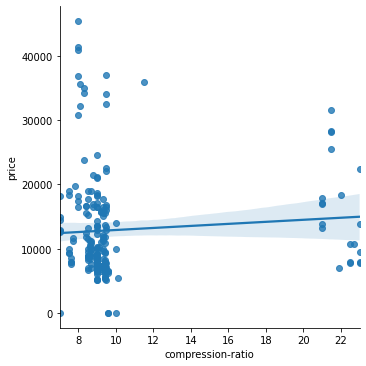

In [38]:
for n in feature_list[:-1]:
    sns.lmplot(x = n, y = 'price', data = car_data[feature_list])
    plt.show()